In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [5]:
def alpha(t: Tensor) -> Tensor:
    return torch.cos(t * torch.pi / 2)

def sigma(t: Tensor) -> Tensor:
    return torch.sin(t * torch.pi / 2)

def d_alpha(t: Tensor) -> Tensor:
    return -torch.pi / 2 * torch.sin(t * torch.pi / 2)

def d_sigma(t: Tensor) -> Tensor:
    return torch.pi / 2 * torch.cos(t * torch.pi / 2)

In [13]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        d_t = t_end - t_start
        t_middle = t_start + d_t / 2
        v_start = self(t=t_start, x_t=x_t)
        x_middle = x_t + v_start * d_t / 2
        v_middle = self(t=t_middle, x_t=x_middle)
        return x_t + d_t * v_middle
        # return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [14]:
# run this cell
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_0 = Tensor(make_moons(256, noise=0.05)[0])
    t = torch.rand(len(x_0), 1)
    eps = torch.randn_like(x_0)
    x_t = alpha(t) * x_0 + sigma(t) * eps

    target = d_alpha(t) * x_0 + d_sigma(t) * eps
    pred = flow(t=t, x_t=x_t)
    
    optimizer.zero_grad()
    loss_fn(pred, target).backward()
    optimizer.step()

In [ ]:
# don't run this cell
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

# Sampling

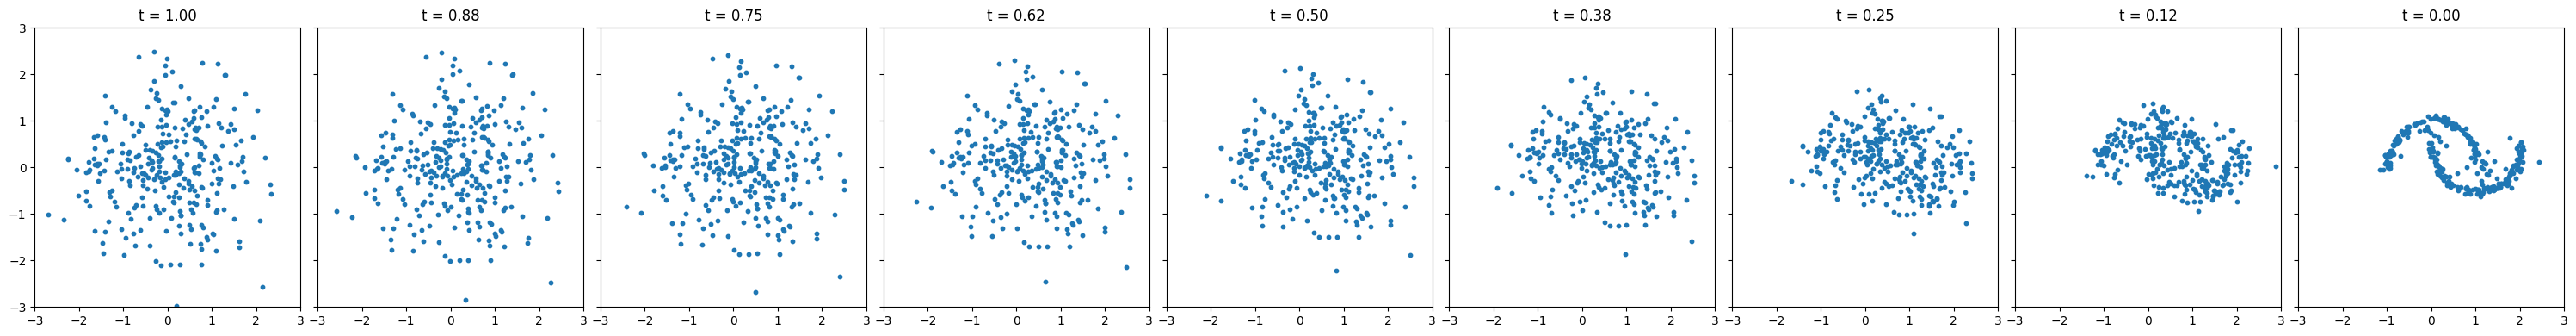

In [ ]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
# time_steps = torch.linspace(0, 1.0, n_steps + 1)
# reverse time steps for diffusion sampling
time_steps = torch.linspace(1.0, 0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()